# Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# Load data

In [2]:
# Random subsample of train data
df_train = pd.read_csv('data/mnist/mnist_train.csv').sample(frac=0.1)
df_test = pd.read_csv('data/mnist/mnist_test.csv')

In [3]:
df_train.shape

(6000, 785)

In [4]:
df_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
23320,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53279,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32238,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30445,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9059,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_train_sub = df_train.sample(frac=0.2)
X_train = df_train_sub.drop('label', axis=1)
y_train = df_train_sub['label']

X_test = df_test.drop('label', axis=1)
y_test = df_test['label']

In [6]:
def plot_image(row):
    plt.imshow(np.reshape(np.array(row.drop('label')), (-1, 28)), cmap='gray')
    plt.title(f'Class = {row["label"]}')
    plt.show()

# EDA

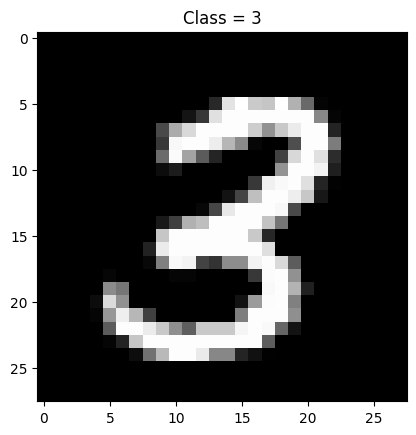

In [8]:
plot_image(df_train.iloc[0])

# Models

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.model_selection import ShuffleSplit, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [10]:
# Perform a single train-validation split
ss = ShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=42)

In [11]:
# Declare scores to be used
scoring = {
    'Bacc': make_scorer(balanced_accuracy_score),
    'Prec': make_scorer(precision_score, average='micro'),
    'Rec': make_scorer(recall_score, average='micro')
}

In [12]:
def print_rs_metrics(rs_model):
    for t in ['train', 'test']:
        if t == 'test':
            print('Validation\n---------------')
        else:
            print('Train\n---------------')
        print('Balanced Acc:', rs_model.cv_results_[f'mean_{t}_Bacc'][rs_model.best_index_].round(2))
        print('Recall:', rs_model.cv_results_[f'mean_{t}_Rec'][rs_model.best_index_].round(2))
        print('Precision:', rs_model.cv_results_[f'mean_{t}_Prec'][rs_model.best_index_].round(2))
        print()

In [13]:
def display_cm(model, X_train, y_train, cross_val_obj):
    train_idx, val_idx = next(cross_val_obj.split(X_train))

    if 'keras' in str(type(model)):
        y_val_pred = model.predict(X_train.iloc[val_idx])
        y_val_pred = y_val_pred.argmax(axis=1)
    else:
        model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        y_val_pred = model.predict(X_train.iloc[val_idx])


    ConfusionMatrixDisplay.from_predictions(y_train.iloc[val_idx], y_val_pred)
    plt.title('Validation set')
    plt.xticks(range(10), range(10))
    plt.show()

## kNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [137]:
knn_pipe = Pipeline([
    ('scaler', None),
    ('knn', KNeighborsClassifier())
])

params = {
    'scaler': [MinMaxScaler(), RobustScaler(), StandardScaler()],
    'knn__n_neighbors': np.arange(2, 10),
    'knn__p': np.arange(1, 5),
}

knn = RandomizedSearchCV(knn_pipe,
                           n_iter=30,
                           param_distributions=params,
                           scoring=scoring,
                           cv=ss,
                           refit="Bacc",
                           return_train_score=True,
                           n_jobs=-1)

knn.fit(X_train, y_train)

print('Best:')
print(knn.best_params_)

Best:
{'scaler': MinMaxScaler(), 'knn__p': 3, 'knn__n_neighbors': 2}


In [138]:
print_rs_metrics(knn)

Train
---------------
Balanced Acc: 0.93
Recall: 0.93
Precision: 0.93

Validation
---------------
Balanced Acc: 0.87
Recall: 0.87
Precision: 0.87



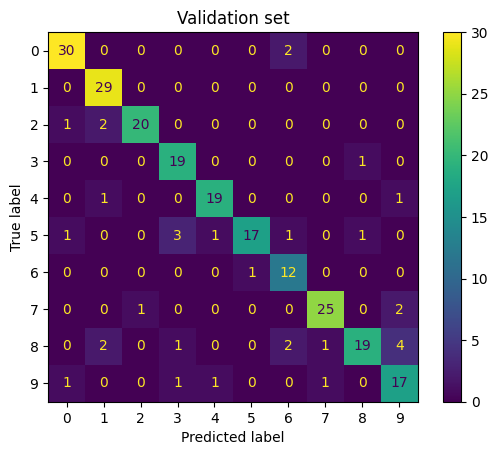

In [49]:
display_cm(knn.best_estimator_, X_train, y_train, ss)

## Random Forest

In [141]:
from sklearn.ensemble import RandomForestClassifier

In [146]:
rf = RandomForestClassifier(n_jobs=-1)

params = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [5, 10, 20, 30],
    'max_depth': [5, 8, 10, 20],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9],
    'max_samples': [None, 0.5, 0.7, 0.9],
    'max_leaf_nodes': [None, 20, 50],
}

rf = RandomizedSearchCV(rf,
                        n_iter=50,
                        param_distributions=params,
                        scoring=scoring,
                        cv=ss,
                        refit="Bacc",
                        return_train_score=True,
                        n_jobs=-1)

rf.fit(X_train, y_train)

print('Best:')
print(rf.best_params_)

Best:
{'n_estimators': 300, 'min_samples_split': 5, 'max_samples': 0.9, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini'}


In [147]:
print_rs_metrics(rf)

Train
---------------
Balanced Acc: 1.0
Recall: 1.0
Precision: 1.0

Validation
---------------
Balanced Acc: 0.85
Recall: 0.85
Precision: 0.85



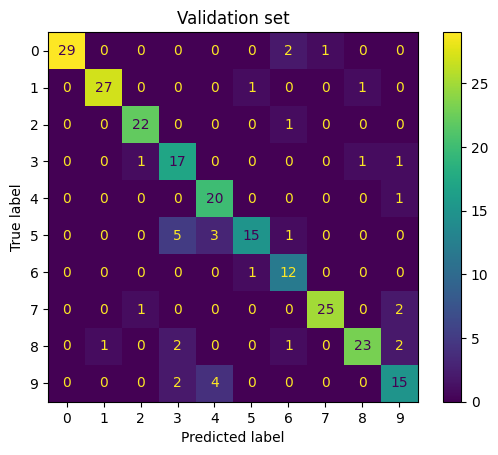

In [148]:
display_cm(rf.best_estimator_, X_train, y_train, ss)

## Neural Network

In [52]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Rescaling, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [53]:
# Create train/validation data manually

train_idx, val_idx = next(ss.split(X_train))

X_train2 = X_train.iloc[train_idx]
y_train2 = y_train.iloc[train_idx]

X_val = X_train.iloc[val_idx]
y_val = y_train.iloc[val_idx]

In [54]:
# Create a NN model

def get_nn_model():
    nn = Sequential([
        Input(X_train.shape[1]),
        Rescaling(1/255),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax'),
    ])

    nn.compile(optimizer=Adam(learning_rate=0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
    return nn

In [55]:
# Train the model with early stopping
nn = get_nn_model()
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
nn_results = nn.fit(X_train2, y_train2, epochs=100, batch_size=64,
                    validation_data=(X_val, y_val), callbacks=[es])

2023-11-23 16:08:52.958249: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-11-23 16:08:52.958291: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-23 16:08:52.958342: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ibci-Latitude-7490): /proc/driver/nvidia/version does not exist
2023-11-23 16:08:52.958999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
15/15 [==============================] - 1s 27ms/step - loss: 2.3239 - accuracy: 0.2302 - val_loss: 2.1291 - val_accuracy: 0.4542
Epoch 2/100
15/15 [==============================] - 0s 11ms/step - loss: 1.3578 - accuracy: 0.5698 - val_loss: 2.0009 - val_accuracy: 0.6208
Epoch 3/100
15/15 [==============================] - 0s 11ms/step - loss: 0.9300 - accuracy: 0.7271 - val_loss: 1.8990 - val_accuracy: 0.6667
Epoch 4/100
15/15 [==============================] - 0s 11ms/step - loss: 0.7125 - accuracy: 0.8000 - val_loss: 1.8063 - val_accuracy: 0.6792
Epoch 5/100
15/15 [==============================] - 0s 10ms/step - loss: 0.5646 - accuracy: 0.8583 - val_loss: 1.7279 - val_accuracy: 0.6792
Epoch 6/100
15/15 [==============================] - 0s 14ms/step - loss: 0.4585 - accuracy: 0.8833 - val_loss: 1.6536 - val_accuracy: 0.6708
Epoch 7/100
15/15 [==============================] - 0s 13ms/step - loss: 0.3744 - accuracy: 0.9167 - val_loss: 1.5737 - val_accuracy: 0.6875
Epoch 

In [56]:
y_val_probs = nn.predict(X_val, verbose=0)
y_val_preds = y_val_probs.argmax(axis=1)
print('Validation Bal. Accuracy:', balanced_accuracy_score(y_val, y_val_preds).round(2))

Validation Bal. Accuracy: 0.88


8/8 [==============================] - 0s 3ms/step


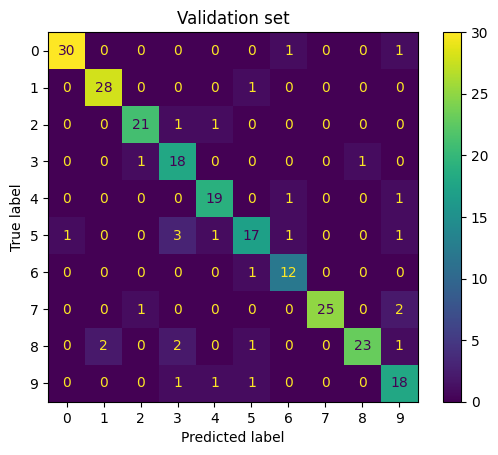

In [58]:
display_cm(nn, X_train, y_train, ss)

## CNN

In [26]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Rescaling, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten

In [16]:
# Create train/validation data manually

train_idx, val_idx = next(ss.split(X_train))

X_train2 = X_train.iloc[train_idx]
y_train2 = y_train.iloc[train_idx]

X_val = X_train.iloc[val_idx]
y_val = y_train.iloc[val_idx]

In [17]:
X_train2.values.reshape((X_train2.shape[0], 28, 28, 1)).shape

(960, 28, 28, 1)

In [18]:
# Convert DF to "images" (numpy arrays of 28x28 in grayscale)

train2_images = X_train2.values.reshape((X_train2.shape[0], 28, 28, 1))
val_images = X_val.values.reshape((X_val.shape[0], 28, 28, 1))

In [69]:
def get_cnn_model():
    cnn = Sequential([
        Input((28, 28, 1)),
        Rescaling(1/255),
        Conv2D(64, kernel_size=3, activation='relu'),
        Conv2D(64, kernel_size=3, activation='relu'),
        Dropout(0.1),
        MaxPooling2D(2),
        Conv2D(32, kernel_size=3, activation='relu'),
        Conv2D(32, kernel_size=3, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(10, activation='softmax'),
    ])

    cnn.compile(optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return cnn

In [35]:
# Train the model with early stopping
cnn = get_cnn_model()
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
cnn_results = cnn.fit(train2_images, y_train2, epochs=100, batch_size=64,
                      validation_data=(val_images, y_val), callbacks=[es])

Epoch 1/100
15/15 [==============================] - 3s 115ms/step - loss: 1.2726 - accuracy: 0.6229 - val_loss: 2.0944 - val_accuracy: 0.5417
Epoch 2/100
15/15 [==============================] - 2s 101ms/step - loss: 0.3937 - accuracy: 0.8823 - val_loss: 1.9820 - val_accuracy: 0.5833
Epoch 3/100
15/15 [==============================] - 2s 103ms/step - loss: 0.2170 - accuracy: 0.9292 - val_loss: 1.8651 - val_accuracy: 0.5708
Epoch 4/100
15/15 [==============================] - 2s 101ms/step - loss: 0.1340 - accuracy: 0.9677 - val_loss: 1.8389 - val_accuracy: 0.4083
Epoch 5/100
15/15 [==============================] - 2s 105ms/step - loss: 0.0916 - accuracy: 0.9792 - val_loss: 1.8419 - val_accuracy: 0.2542
Epoch 6/100
15/15 [==============================] - 2s 106ms/step - loss: 0.0754 - accuracy: 0.9875 - val_loss: 1.8581 - val_accuracy: 0.1542
Epoch 7/100
15/15 [==============================] - 2s 103ms/step - loss: 0.0490 - accuracy: 0.9937 - val_loss: 1.8318 - val_accuracy: 0.1458

In [36]:
y_val_probs = cnn.predict(val_images, verbose=0)
y_val_preds = y_val_probs.argmax(axis=1)
print('Validation Bal. Accuracy:', balanced_accuracy_score(y_val, y_val_preds).round(2))

Validation Bal. Accuracy: 0.95


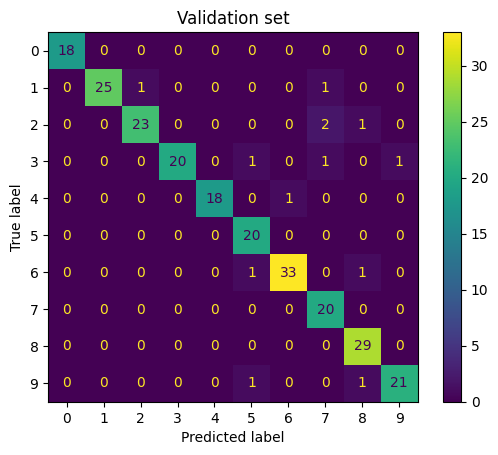

In [37]:
ConfusionMatrixDisplay.from_predictions(y_val, y_val_preds)
plt.title('Validation set')
plt.show()

# Test

Choose best models: KNN and CNN.

First train with all train data, not just a subsample.

One interesting thing is that CNNs are faster to train and learn better on images compared to classical ML models. This is mainly because of its specialized architecture for learning important image patterns that help in the target prediction. Also, convolutional layers do not have too many parameters and pooling layers help in reducing the image size.

## kNN

In [62]:
X_train_full = df_train.drop('label', axis=1)
y_train_full = df_train['label']

In [152]:
knn.best_estimator_.fit(X_train_full, y_train_full)
y_test_pred = knn.best_estimator_.predict(X_test)
print('Test Balanced Acc:', balanced_accuracy_score(y_test, y_test_pred).round(2))

Test Balanced Acc: 0.93


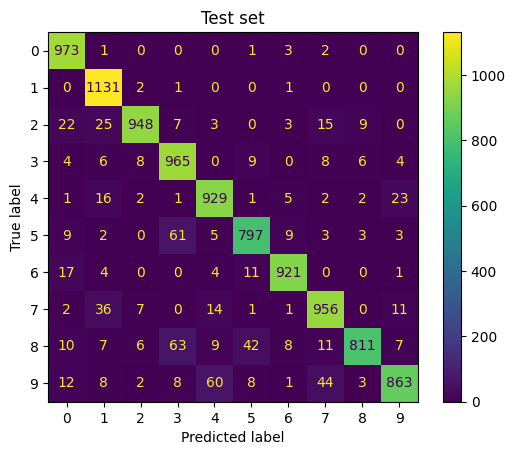

In [151]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.title('Test set')
plt.show()

## CNN

In [72]:
# Convert DF to "images" (numpy arrays of 28x28 in grayscale)
train_images_full = X_train_full.values.reshape((X_train_full.shape[0], 28, 28, 1))
test_images_full = X_test.values.reshape((X_test.shape[0], 28, 28, 1))

In [70]:
# Train the model with early stopping
cnn = get_cnn_model()
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
cnn_results = cnn.fit(train_images_full, y_train_full, epochs=100, batch_size=64,
                      validation_split=0.1, callbacks=[es])

Epoch 1/100
85/85 [==============================] - 10s 107ms/step - loss: 0.4925 - accuracy: 0.8472 - val_loss: 1.6211 - val_accuracy: 0.5017
Epoch 2/100
85/85 [==============================] - 9s 104ms/step - loss: 0.1591 - accuracy: 0.9517 - val_loss: 1.2119 - val_accuracy: 0.6267
Epoch 3/100
85/85 [==============================] - 10s 114ms/step - loss: 0.1044 - accuracy: 0.9691 - val_loss: 0.9396 - val_accuracy: 0.7017
Epoch 4/100
85/85 [==============================] - 10s 114ms/step - loss: 0.0750 - accuracy: 0.9785 - val_loss: 0.4205 - val_accuracy: 0.9100
Epoch 5/100
85/85 [==============================] - 10s 114ms/step - loss: 0.0528 - accuracy: 0.9848 - val_loss: 0.2027 - val_accuracy: 0.9617
Epoch 6/100
85/85 [==============================] - 10s 115ms/step - loss: 0.0414 - accuracy: 0.9891 - val_loss: 0.0872 - val_accuracy: 0.9750
Epoch 7/100
85/85 [==============================] - 10s 114ms/step - loss: 0.0306 - accuracy: 0.9922 - val_loss: 0.0654 - val_accuracy: 

In [73]:
y_test_probs = cnn.predict(test_images_full, verbose=0)
y_test_preds = y_test_probs.argmax(axis=1)
print('Test Bal. Accuracy:', balanced_accuracy_score(y_test, y_test_preds).round(2))

Test Bal. Accuracy: 0.98


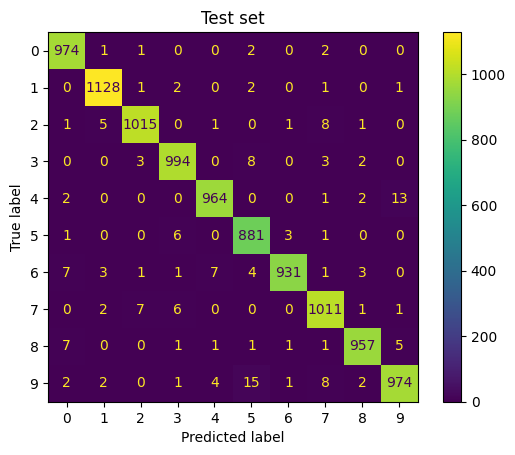

In [74]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_preds)
plt.title('Test set')
plt.show()